In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [14]:
sns.set_style("whitegrid")

BASE_DIR = os.path.dirname(os.getcwd())
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')

In [15]:
try:
    df_attendance = pd.read_csv(os.path.join(DATA_RAW_DIR, 'attendance.csv'))
    df_games = pd.read_csv(os.path.join(DATA_RAW_DIR, 'games.csv'))
    df_standings = pd.read_csv(os.path.join(DATA_RAW_DIR, 'standings.csv'))
    
    print("Berhasil load semua data.")
except FileNotFoundError as e:
    print(f"Error: File tidak ditemukan. \n{e}")

Berhasil load semua data.


In [16]:
print("DATA ATTENDANCE")
display(df_attendance.head())


print("\nINFO DATASET")
df_attendance.info()

DATA ATTENDANCE


,team,team_name,year,total,home,away,week,weekly_attendance
0,Arizona,Cardinals,2000,893926,387475,506451,1,77434.0
1,Arizona,Cardinals,2000,893926,387475,506451,2,66009.0
2,Arizona,Cardinals,2000,893926,387475,506451,3,NaN
3,Arizona,Cardinals,2000,893926,387475,506451,4,71801.0
4,Arizona,Cardinals,2000,893926,387475,506451,5,66985.0



INFO DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10846 entries, 0 to 10845
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   team               10846 non-null  object 
 1   team_name          10846 non-null  object 
 2   year               10846 non-null  int64  
 3   total              10846 non-null  int64  
 4   home               10846 non-null  int64  
 5   away               10846 non-null  int64  
 6   week               10846 non-null  int64  
 7   weekly_attendance  10208 non-null  float64
dtypes: float64(1), int64(5), object(2)
memory usage: 678.0+ KB


### **Cek & Handling Missing Values**

In [17]:
# 1. Cek jumlah missing values per kolom
print("Jumlah Missing Values")
print(df_attendance.isnull().sum())

# 2. Lihat baris yang weekly_attendance-nya kosong
print("\nContoh Data Kosong")
display(df_attendance[df_attendance['weekly_attendance'].isnull()].head())

df_clean = df_attendance.dropna(subset=['weekly_attendance']).copy()

print(f"\nJumlah baris sebelum drop: {len(df_attendance)}")
print(f"Jumlah baris setelah drop: {len(df_clean)}")

Jumlah Missing Values
team                   0
team_name              0
year                   0
total                  0
home                   0
away                   0
week                   0
weekly_attendance    638
dtype: int64

Contoh Data Kosong


,team,team_name,year,total,home,away,week,weekly_attendance
2,Arizona,Cardinals,2000,893926,387475,506451,3,NaN
31,Atlanta,Falcons,2000,964579,422814,541765,15,NaN
47,Baltimore,Ravens,2000,1062373,551695,510678,14,NaN
54,Buffalo,Bills,2000,1098587,560695,537892,4,NaN
71,Carolina,Panthers,2000,1095192,583489,511703,4,NaN



Jumlah baris sebelum drop: 10846
Jumlah baris setelah drop: 10208


In [18]:
# 1. Buat kolom baru 'full_name'
df_clean['full_name'] = df_clean['team'] + ' ' + df_clean['team_name']

# 2. Cek semua nama tim unik yang ada
unique_teams = sorted(df_clean['full_name'].unique())

print("\nDaftar Semua Tim (Cek Duplikasi Kota)")
for team in unique_teams:
    print(team)


Daftar Semua Tim (Cek Duplikasi Kota)
Arizona Cardinals
Atlanta Falcons
Baltimore Ravens
Buffalo Bills
Carolina Panthers
Chicago Bears
Cincinnati Bengals
Cleveland Browns
Dallas Cowboys
Denver Broncos
Detroit Lions
Green Bay Packers
Houston Texans
Indianapolis Colts
Jacksonville Jaguars
Kansas City Chiefs
Los Angeles Chargers
Los Angeles Rams
Miami Dolphins
Minnesota Vikings
New England Patriots
New Orleans Saints
New York Giants
New York Jets
Oakland Raiders
Philadelphia Eagles
Pittsburgh Steelers
San Diego Chargers
San Francisco 49ers
Seattle Seahawks
St. Louis Rams
Tampa Bay Buccaneers
Tennessee Titans
Washington Redskins


### **Fixing & Saving Data**

In [19]:
# 1. PREPARE STANDINGS (Klasemen)
df_standings_clean = df_standings.copy()
df_standings_clean['full_name'] = df_standings_clean['team'] + ' ' + df_standings_clean['team_name']

# Mapping Nama Tim
team_mapping = {
    'St. Louis Rams': 'Los Angeles Rams',
    'San Diego Chargers': 'Los Angeles Chargers',
    'Oakland Raiders': 'Las Vegas Raiders',
    'Houston Oilers': 'Tennessee Titans',
    'Tennessee Oilers': 'Tennessee Titans'
}
df_standings_clean['team_clean'] = df_standings_clean['full_name'].replace(team_mapping)
cols_standings = ['year', 'team_clean', 'wins', 'loss', 'playoffs', 'sb_winner']
df_standings_final = df_standings_clean[cols_standings]


# 2. PREPARE GAMES (Detail Pertandingan)
df_games_clean = df_games.copy()

# A. FIX TYPE DATA
# Paksa kolom 'week' jadi angka. Jika ada teks aneh (misal 'SuperBowl'), ubah jadi NaN lalu buang/isi.
df_games_clean['week'] = pd.to_numeric(df_games_clean['week'], errors='coerce')
# Isi NaN dengan 0 atau drop (kita pilih drop yang kosong agar jadi integer bersih)
df_games_clean = df_games_clean.dropna(subset=['week'])
# Ubah jadi integer (bilangan bulat) agar sama dengan attendance
df_games_clean['week'] = df_games_clean['week'].astype(int)

# B. Standardisasi Nama Home Team
df_games_clean['home_full_name'] = df_games_clean['home_team_city'] + ' ' + df_games_clean['home_team_name']
df_games_clean['home_team_clean'] = df_games_clean['home_full_name'].replace(team_mapping)

# C. Hitung Home Score & Away Score
conditions = [
    df_games_clean['home_team'] == df_games_clean['winner'],
    df_games_clean['home_team'] != df_games_clean['winner']
]
choices_home = [df_games_clean['pts_win'], df_games_clean['pts_loss']]
choices_away = [df_games_clean['pts_loss'], df_games_clean['pts_win']]

df_games_clean['home_score'] = np.select(conditions, choices_home, default=df_games_clean['pts_win'])
df_games_clean['away_score'] = np.select(conditions, choices_away, default=df_games_clean['pts_loss'])

cols_games = ['year', 'week', 'home_team_clean', 'away_team', 'home_score', 'away_score', 'day']
df_games_final = df_games_clean[cols_games]


# 3. MERGING

# Step A: Gabung Attendance + Standings
df_step1 = pd.merge(
    df_clean, 
    df_standings_final, 
    on=['team_clean', 'year'], 
    how='left'
)

# Step B: Gabung Hasil Step A + Games
df_final = pd.merge(
    df_step1,
    df_games_final,
    left_on=['team_clean', 'year', 'week'],       
    right_on=['home_team_clean', 'year', 'week'], 
    how='left'
)

# 4. CLEANING AKHIR & SIMPAN
if 'home_team_clean' in df_final.columns:
    df_final.drop(columns=['home_team_clean'], inplace=True)

output_path = os.path.join(DATA_PROCESSED_DIR, 'nfl_attendance_complete.csv')
df_final.to_csv(output_path, index=False)

print(f"\n3 File berhasil digabung.")
print(f"Dimensi Final: {df_final.shape}")
display(df_final.head())

KeyError: 'team_clean'

In [20]:
# Anggota 2 cukup jalankan ini:
import pandas as pd
import os

# Definisikan path (sesuaikan dengan struktur folder laptop dia)
# Asumsi dia ada di folder 'notebooks'
path_file = os.path.join('..', 'data', 'processed', 'nfl_attendance_complete.csv')

# Load langsung hasil kerja Anggota 1
df_final = pd.read_csv(path_file)
print("Data Final berhasil di-load!")
display(df_final.head())

Data Final berhasil di-load!


,team,team_name,year,total,home,away,week,weekly_attendance,full_name,team_clean,wins,loss,playoffs,sb_winner,away_team,home_score,away_score,day
0,Arizona,Cardinals,2000,893926,387475,506451,1,77434.0,Arizona Cardinals,Arizona Cardinals,3,13,No Playoffs,No Superbowl,NaN,NaN,NaN,NaN
1,Arizona,Cardinals,2000,893926,387475,506451,2,66009.0,Arizona Cardinals,Arizona Cardinals,3,13,No Playoffs,No Superbowl,Dallas Cowboys,32.0,31.0,Sun
2,Arizona,Cardinals,2000,893926,387475,506451,4,71801.0,Arizona Cardinals,Arizona Cardinals,3,13,No Playoffs,No Superbowl,Green Bay Packers,3.0,29.0,Sun
3,Arizona,Cardinals,2000,893926,387475,506451,5,66985.0,Arizona Cardinals,Arizona Cardinals,3,13,No Playoffs,No Superbowl,NaN,NaN,NaN,NaN
4,Arizona,Cardinals,2000,893926,387475,506451,6,44296.0,Arizona Cardinals,Arizona Cardinals,3,13,No Playoffs,No Superbowl,Cleveland Browns,29.0,21.0,Sun


In [21]:
attendance_summary = (
    df_final.groupby('team_clean')['weekly_attendance']
    .mean()
    .reset_index()
    .sort_values(by='weekly_attendance', ascending=False)
)

attendance_summary.head(10)


,team_clean,weekly_attendance
8,Dallas Cowboys,74735.418750
31,Washington Redskins,74197.356250
23,New York Giants,74074.446875
24,New York Jets,72431.118750
9,Denver Broncos,71190.037500
15,Kansas City Chiefs,70206.253125
25,Philadelphia Eagles,69877.025000
11,Green Bay Packers,69715.062500
4,Carolina Panthers,69682.931250
21,New England Patriots,68727.471875


In [22]:
win_attendance = (
    df_final.groupby('team_clean')
    .agg({
        'wins': 'mean',
        'weekly_attendance': 'mean'
    })
    .reset_index()
    .sort_values(by='wins', ascending=False)
)

win_attendance.head(10)


,team_clean,wins,weekly_attendance
21,New England Patriots,11.85,68727.471875
26,Pittsburgh Steelers,10.25,65418.531250
13,Indianapolis Colts,9.85,64813.653125
11,Green Bay Packers,9.85,69715.062500
2,Baltimore Ravens,9.50,68201.487500
25,Philadelphia Eagles,9.50,69877.025000
22,New Orleans Saints,9.15,68622.243750
9,Denver Broncos,9.10,71190.037500
28,Seattle Seahawks,9.10,66751.090625
8,Dallas Cowboys,8.40,74735.418750


# Visualisasi

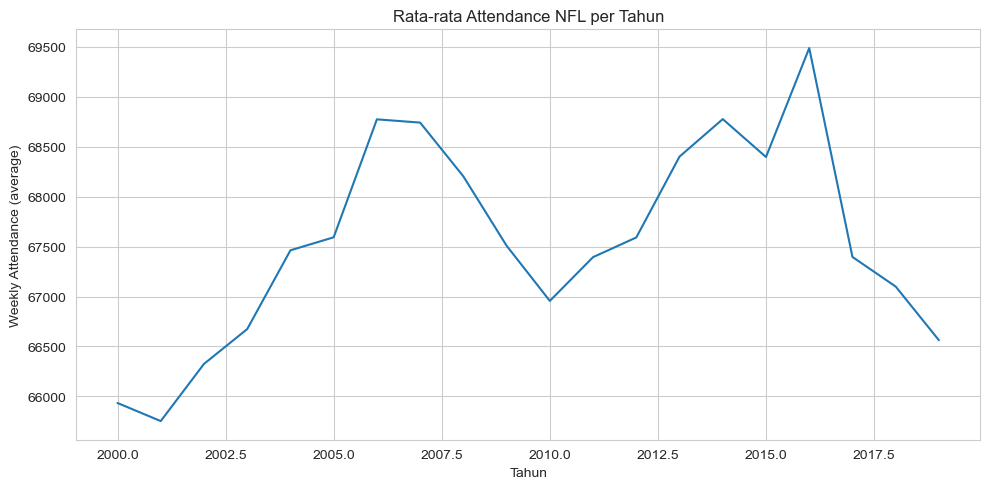

In [23]:
#Tren Attendance per Tahun
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_final.groupby('year')['weekly_attendance'].mean().reset_index(),
    x='year',
    y='weekly_attendance'
)
plt.title("Rata-rata Attendance NFL per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Weekly Attendance (average)")
plt.tight_layout()
plt.show()


Grafik rata-rata kehadiran mingguan NFL per tahun menunjukkan pola yang dinamis dari tahun 2000 hingga 2018. Setelah dimulai pada titik rendah dan menunjukkan kenaikan yang kuat hingga mencapai puncak pertamanya di sekitar tahun 2006, tren ini mengalami penurunan signifikan hingga 2010. Namun, dari tahun 2011 hingga 2016, terjadi pemulihan dan peningkatan kuat yang mencapai puncak absolut tertinggi dalam periode ini, yaitu hampir 69.500 penonton rata-rata per minggu. Sayangnya, puncak ini diikuti oleh penurunan yang sangat tajam dan drastis pada tahun 2017 dan 2018, mengakhiri periode yang ditampilkan dengan rata-rata kehadiran yang jauh lebih rendah, kembali ke level awal dekade 2000-an.

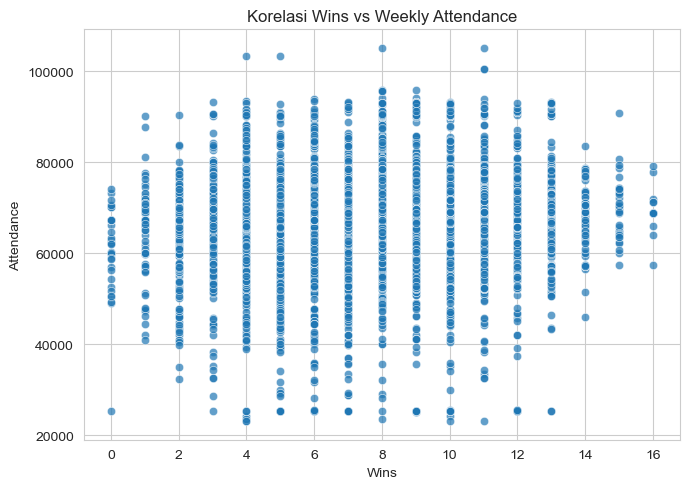

In [24]:
# Korelasi Wins vs Attendance (Scatter Plot)
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_final,
    x='wins',
    y='weekly_attendance',
    alpha=0.7
)
plt.title("Korelasi Wins vs Weekly Attendance")
plt.xlabel("Wins")
plt.ylabel("Attendance")
plt.tight_layout()
plt.show()


Berdasarkan *scatter plot* ini:

> **Jumlah kemenangan (*Wins*) sebuah tim NFL tampaknya memiliki korelasi yang sangat lemah atau hampir tidak ada korelasi langsung dengan rata-rata kehadiran penonton (*Attendance*) tim tersebut.**

Ini menunjukkan bahwa faktor-faktor lain selain catatan menang-kalah tim—seperti ukuran dan loyalitas basis penggemar, kapasitas stadion, lokasi geografis, atau nilai historis tim—jauh lebih dominan dalam menentukan rata-rata kehadiran mingguan.

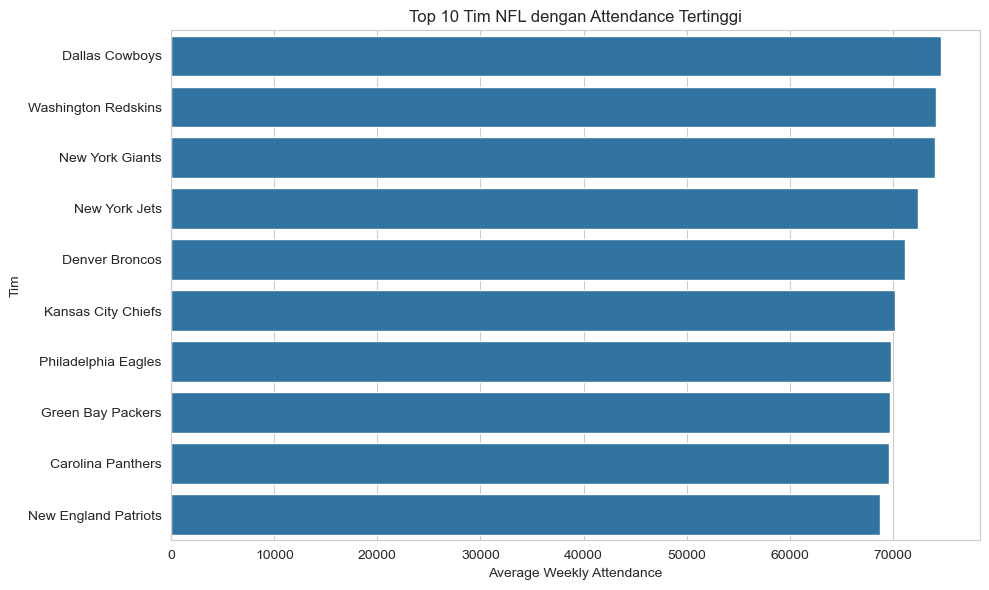

In [28]:
#Top 10 Tim dengan Attendance Terbesar
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10,
    y='team_clean',
    x='weekly_attendance'
)

plt.title("Top 10 Tim NFL dengan Attendance Tertinggi")
plt.xlabel("Average Weekly Attendance")
plt.ylabel("Tim")

plt.tight_layout()
plt.show()

### Top 10 Tim NFL dengan Kehadiran Tertinggi

Grafik batang horizontal ini menampilkan **Top 10 Tim NFL berdasarkan Rata-rata Kehadiran Mingguan (*Average Weekly Attendance*)**.

* **Peringkat Puncak:** Tim **Dallas Cowboys** menempati posisi teratas dengan rata-rata kehadiran tertinggi (sedikit di atas 70.000).
* **Peringkat Berikutnya:** Diikuti ketat oleh **Washington Redskins** dan **New York Giants**, yang menunjukkan bahwa tim-tim dengan basis penggemar besar dan stadion berkapasitas tinggi mendominasi daftar ini.
* **Kesenjangan Kecil:** Perlu dicatat bahwa perbedaan rata-rata kehadiran antara tim di posisi 1 (Dallas Cowboys) hingga tim di posisi 10 (New England Patriots) secara visual relatif kecil, semua berkisar di atas 70.000 (meskipun sumbu X dimulai dari 0).

> **Kesimpulan:** Dallas Cowboys adalah pemimpin kehadiran penonton, tetapi 10 tim teratas ini semuanya mencatat rata-rata kehadiran mingguan yang sangat tinggi dan kompetitif, dengan perbedaan yang tipis antar peringkat.

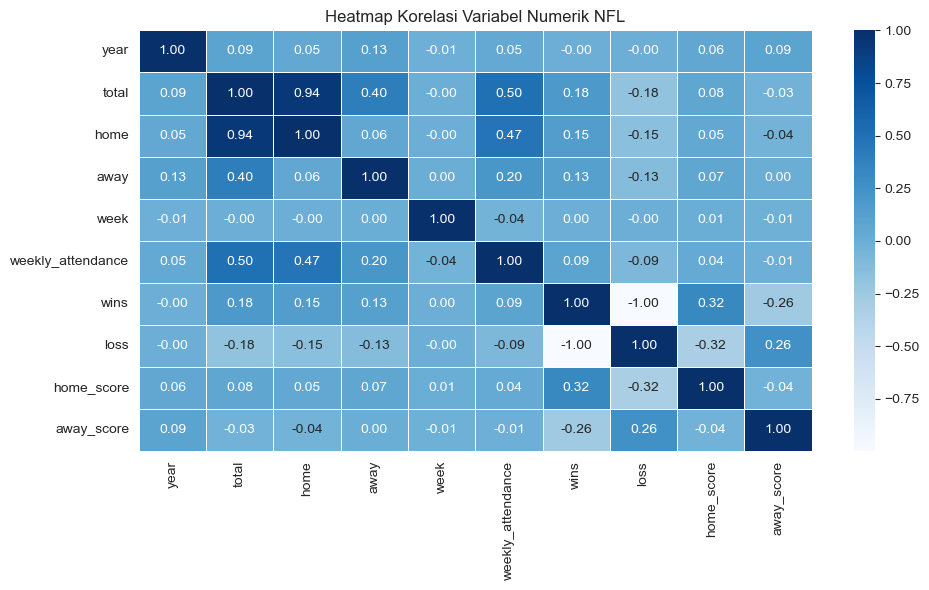

In [32]:
plt.figure(figsize=(10, 6))

corr = df_final.select_dtypes(include='number').corr()

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    linewidths=0.5
)

plt.title("Heatmap Korelasi Variabel Numerik NFL")
plt.tight_layout()
plt.show()


Korelasi yang paling penting adalah bahwa rata-rata kehadiran mingguan ($weekly\_attendance$) sangat dipengaruhi oleh jumlah total pertandingan dan pertandingan kandang, tetapi TIDAK dipengaruhi oleh rekor menang-kalah (wins atau loss).